# Working with empirical measurements and model output

---

## Overview
No rocket science here, but a couple of clean examples of how to plot empirical data atop gridded, interpolated distributions.

---

## Imports

In [198]:
%load_ext autoreload
%autoreload 2

import intake
import numpy as np
import xarray as xr

import cftime

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.util as cutil

import pyleoclim as pyleo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
def lon_180_to_360(x):
    return x % 360

## Load Data

### C-iTRACE
We'll start by loading some model output of neodymium isotopes from C-iTRACE, calculating eNd and selecting a slice to work with.

In [3]:
from pathlib import Path
PF_data_dir = Path('/Users/jlanders/PycharmProjects/PangeoForge_recipes/C-iTRACE/data')

In [5]:
file_name = 'ctrace.decadal.ND143.nc'
ds_Nd143 = xr.open_dataset(PF_data_dir/'netcdf3'/file_name, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)

file_name = 'ctrace.decadal.ND144.nc'
ds_Nd144 = xr.open_dataset(PF_data_dir/'netcdf3'/file_name, use_cftime=True)#, engine='netcdf4', decode_coords=True)#.load()#, decode_coords=True)
# ds_Nd143

In [6]:
def epsNd(Nd):
    (Nd143, Nd144) = Nd
    Nd_CHUR = 0.512638
    scaler = 1000
    return (np.divide(Nd143,Nd144)*1/Nd_CHUR-1)*10**4


In [7]:
time_slice = slice(-8, -5)
ds_Nd143_sub = ds_Nd143.sel(dict(time=time_slice)).copy()
ds_Nd144_sub = ds_Nd144.sel(dict(time=time_slice)).copy()

In [8]:
epsNd_tmp = xr.apply_ufunc(epsNd, (ds_Nd143_sub['ND143'],ds_Nd144_sub['ND144']))
epsNd_tmp.name = 'eNd'

/Users/jlanders/opt/miniconda3/envs/pyleoclim_dev_sphinx/lib/python3.10/site-packages/xarray/core/computation.py:761: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)


In [9]:
epsNd_ds = ds_Nd143_sub#.isel(dict(time=0)).copy()
epsNd_ds['eNd'] = (('time', "z_t","nlat", "nlon"), epsNd_tmp.squeeze().data)
epsNd_ds = epsNd_ds.drop_vars(['ND143'])

In [10]:
def convert_z_to_meters(ds):
    cm_to_m = 1/100
    z_t = ds.z_t.data
    ds['z_t_m'] = ("z_t", z_t*cm_to_m)
    ds = ds.swap_dims({'z_t':'z_t_m'})
    return ds

In [11]:
# convert depth from cm to m
epsNd_ds =convert_z_to_meters(epsNd_ds)
epsNd_ds

<xarray.Dataset>
Dimensions:     (nlat: 116, nlon: 100, time: 301, d2: 2, z_t_m: 60)
Coordinates:
    TLAT        (nlat, nlon) float64 ...
    TLONG       (nlat, nlon) float64 ...
  * time        (time) float64 -8.0 -7.99 -7.98 -7.97 ... -5.03 -5.02 -5.01 -5.0
    z_t         (z_t_m) float32 500.0 1.5e+03 2.5e+03 ... 5.125e+05 5.375e+05
  * z_t_m       (z_t_m) float32 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
Dimensions without coordinates: nlat, nlon, d2
Data variables:
    time_bound  (time, d2) float64 ...
    eNd         (time, z_t_m, nlat, nlon) float32 nan nan nan ... nan nan nan
Attributes: (12/16)
    title:                      b30.22_0kaDVT
    history:                    Tue May 11 11:25:01 2021: ncks -A /glade/scra...
    Conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    contents:                   Diagnostic and Prognostic Variables
    source:                     POP, the NCAR/CSM Ocean Component
    revision:                    $Name: ccsm3_0_1_beta22 $
    ...                         ...
    tavg_sum:                   2592000.0
    tavg_sum_qflux:             2592000.0
    NCO:                        netCDF Operators version 4.9.5 (Homepage = ht...
    nco_openmp_thread_number:   1
    conventions:                CF-1.0; http://www.cgd.ucar.edu/cms/eaton/net...
    history_of_appended_files:  Tue May 11 11:25:01 2021: Appended file /glad...

### Poppelemeier et al, 2019
Additionally, let's load data from Poppelemeier et al, 2019. This dataset covers LGM and Holocene eNd values. 

In [12]:
import os
data_dir_path = Path(os.getcwd()).parent.parent/'data'

In [13]:
import pandas as pd
e_nd_csv = pd.read_csv(data_dir_path/'Poppelemeier2019_TableS3.csv', skiprows=2)



In [14]:
eNd_df = e_nd_csv.dropna(subset=['lat', 'lon'])#.drop(index=[0, 283])
eNd_df = eNd_df.apply(pd.to_numeric, errors='ignore').fillna(eNd_df)
eNd_df['lon'] = eNd_df['lon'].apply(lambda x: lon_180_to_360(x))

eNd_df['z_t'] = eNd_df['depth'].astype(float)#*1000
eNd_df.head()

,Core,lat,lon,depth,eNd_HOL,eNd_LGM,eNd_LGM_M_HOL,Reference,Comment,z_t
1,M771/420,-15.2,284.4,516.0,-1.6,NaN,NaN,Ehlert2013,NaN,516.0
2,Pos_292_526_1,59.2,342.8,516.0,-13.1,NaN,NaN,Copard2010,NaN,516.0
3,Nd08_62309,40.4,292.3,522.0,-15.2,NaN,NaN,van de Flierdt2010,NaN,522.0
4,M771/554,-10.4,281.1,522.0,-1.5,NaN,NaN,Ehlert2013,NaN,522.0
5,M772/064_1,-1.9,278.8,529.0,2.2,NaN,NaN,Ehlert2013,NaN,529.0


In [15]:
time_var = 'eNd_HOL'
time_subset = eNd_df[~eNd_df[time_var].isna()]

Let's plot the depths of the samples, which also gives us a sense of the distribution.

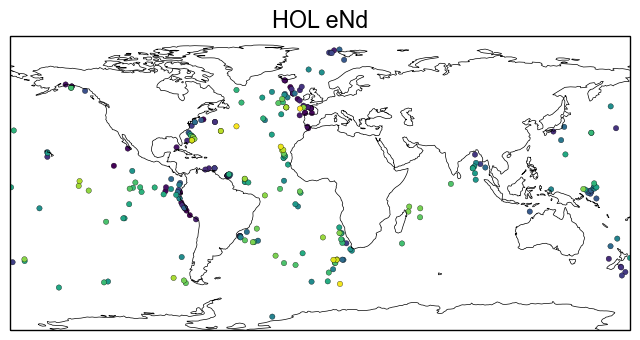

In [16]:
fig = plt.figure(figsize=(8, 4))
data_proj = ccrs.PlateCarree()
ax2 = fig.add_subplot(projection=data_proj)#ccrs.Robinson(central_longitude=0))

ax2.scatter(time_subset['lon'], time_subset['lat'], c=time_subset['depth'],s=15, 
                cmap='viridis', #norm=cf2_kwargs['norm'],
                edgecolors='k',linewidth=.23, transform=data_proj)
    
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)
# add annotations (colorbar, title)
ax2.set_title('{} eNd'.format(time_var.split('_')[1]));

## Surface with Scatter
We'll grab a surface at a time within the Poppelemeier data and build a `pmeshcolor` figure that corresponds to 2000m.

In [17]:
var = 'eNd'
colorbar_units='eNd'

In [18]:
c_snapshot_data = epsNd_ds.sel(time = -5.99, method='nearest')
c_snapshot_data_surf=c_snapshot_data.sel(dict(z_t_m=2000), method='nearest')

c_snapshot_data_surf = c_snapshot_data_surf[var].squeeze()
c_snapshot_data_surf = c_snapshot_data_surf.compute()

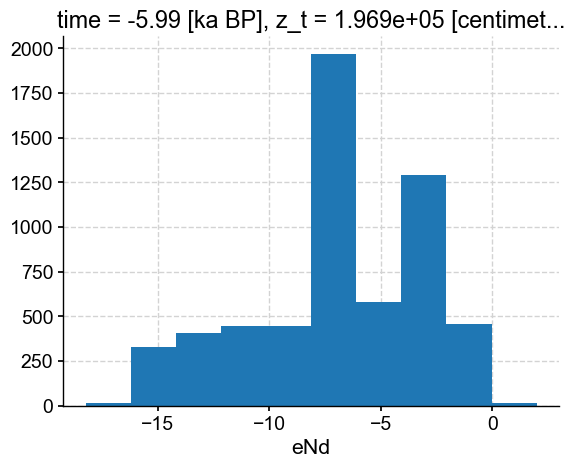

In [19]:
bins =c_snapshot_data_surf.plot.hist()
bin_edges = bins[1]

In [107]:
# establish scale
max_lim = bin_edges[-1]#c_snapshot_data.max()
min_lim = bin_edges[0]#c_snapshot_data.min()

In [106]:
def make_scalar_mappable(lims, cmap, n=None):
    ax_norm = mpl.colors.Normalize(vmin=min(lims), vmax=max(lims), clip=False)
    if type(cmap)==list:
        if n is None:
            ax_cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"])
        else:
            ax_cmap = mpl.colors.LinearSegmentedColormap.from_list("MyCmapName",["r","b"], N=n)
    else:
        if n is None:
            ax_cmap = plt.get_cmap(cmap)
        else:    
            ax_cmap = plt.get_cmap(cmap, n)
    ax_sm = cm.ScalarMappable(norm=ax_norm, cmap=ax_cmap)
    return ax_sm

In [108]:
n_levels= 60
ax2_levels = np.around(np.linspace(min_lim, max_lim, n_levels), decimals=4)#0.0026, .003, 15), decimals=6)
# make scalar mappable
ax2_sm = make_scalar_mappable([min_lim, max_lim],['red', 'blue'] , n_levels)#[0.0026, .003]
cf2_kwargs = {'cmap':ax2_sm.cmap,'levels':ax2_levels, 'norm' : ax2_sm.norm}#mpl.colors.TwoSlopeNorm(vmin=min_val, vcenter=0.0026, vmax=max_val), 'levels':ax2_levels}#SymLogNorm(.00152, linscale=.003)}#, vmin=None, vmax=None, clip=False)ax2_sm.norm}

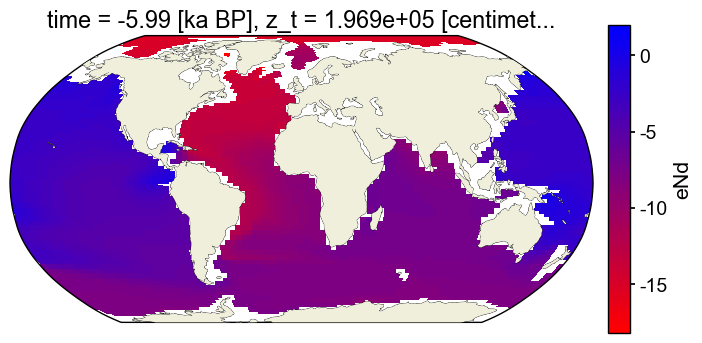

In [31]:
# plt.figure(figsize=(9,5));
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))

c_snapshot_data_surf.plot.pcolormesh(ax=ax2, 
                                   transform=ccrs.PlateCarree(), 
                                   x='TLONG', y='TLAT', 
                                   levels=ax2_levels, 
                                  cmap=cf2_kwargs['cmap'], 
                                  norm=cf2_kwargs['norm'], 
                                  add_colorbar=False);

ax2.coastlines(linewidth=.5)
ax2.add_feature(cfeature.LAND, zorder=14)

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))

It's delightfully straightforward now that we have a colormap and normalization scheme to superimpose the empirical data with circles colored according to their eNd values! Minor protip: specifying `zorder=1` for the coatlines and land feature forces these map aspects to sit below the plotted point. It sounds minor, but with so many measurements near coastlines, points with good model agreement can blend in if a coastline runs through the marker.

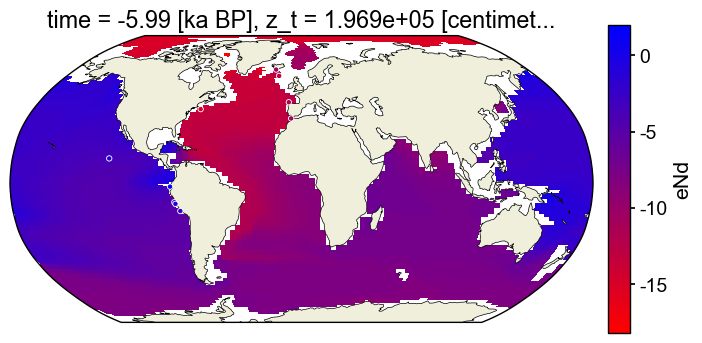

In [153]:
# plt.figure(figsize=(9,5));
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))

c_snapshot_data_surf.plot.pcolormesh(ax=ax2, 
                                   transform=ccrs.PlateCarree(), 
                                   x='TLONG', y='TLAT', 
                                   levels=ax2_levels, 
                                  cmap=cf2_kwargs['cmap'], 
                                  norm=cf2_kwargs['norm'], 
                                  add_colorbar=False)

ax2.add_feature(cfeature.LAND, zorder=1)
ax2.coastlines(linewidth=.5, zorder = 1)

surface_df = time_subset[time_subset['depth'].between(500, 550)]
ax2.scatter(surface_df['lon'].apply(lambda x: lon_180_to_360(x)), surface_df['lat'], c=surface_df['eNd_HOL'],s=15, 
                norm=cf2_kwargs['norm'],cmap=cf2_kwargs['cmap'],
                edgecolors='w',linewidth=.63, transform=ccrs.PlateCarree())

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))

## Section with Scatter
It is similarly straightforward to select a depth transect and then add the empirical data. The only challenge here is in selecting data. As noted in the py(?)ODV notebook, `sel` only works when data coordinates are one dimensional and correspond to dimsnsions. Here we want to select data along a line of longitude so we'll use a two condition `where` filter instead. The returned dataset will maintain its original coordinates, but with a mask applied to data variables.

In [38]:
def between(ds, var, lims):
    _ds = ds.where((ds.coords[var]<max(lims)) & (ds.coords[var]>min(lims)), drop=True)
    return _ds

In [148]:
section_ds = c_snapshot_data.sel(nlon=1)

In [149]:
lims = [340, 342]
section_ds = between(c_snapshot_data, 'TLONG', lims)
section_df = time_subset[time_subset['lon'].between(min(lims), max(lims))]

In [150]:
tmp_surf = section_ds.sel(z_t_m=500, method='nearest')

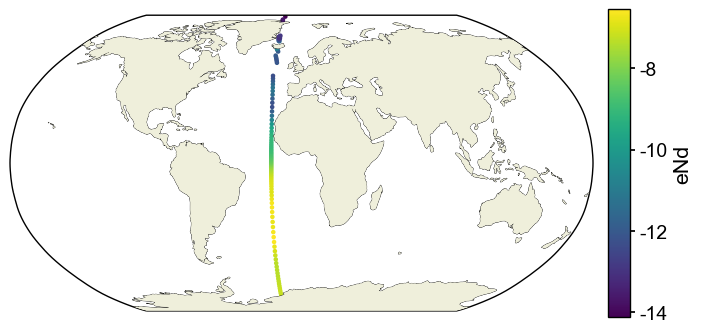

In [53]:
fig = plt.figure(figsize=(8, 4))
# 1 row, 2 columns, .05 space between columns, 8:.3 ratio of left column to right column
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])

# add subplot with specified map projection and coastlines (GeoAxes)
ax2 = fig.add_subplot(gs[0, 0], projection=ccrs.Robinson(central_longitude=0))
ax2.add_feature(cfeature.COASTLINE, edgecolor='k',linewidth=.5)

scatter = ax2.scatter(tmp_surf.TLONG,tmp_surf.TLAT,c=tmp_surf[var].squeeze(), transform=ccrs.PlateCarree(), 
             s=5)
            # cmap=cf2_kwargs['cmap'], norm=cf2_kwargs['norm'])
ax2.add_feature(cfeature.LAND, zorder=14)
ax2.set_global()
ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(scatter,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))


In [202]:
def make_inset_map(ax, lats, lons, central_lon=0,central_lat=0, size_scaler=.25, loc="lower right"):
    axin = inset_axes(ax, width=size_scaler*5, height=size_scaler*5, loc=loc, 
                 axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                 axes_kwargs=dict(projection=ccrs.Orthographic(central_latitude=central_lat, 
                                                               central_longitude=central_lon)))
                                                               # central_lon)))

    axin.coastlines(linewidth=.5)
    axin.add_feature(cfeature.LAND, zorder=14)
    axin.plot(lons, lats, transform=ccrs.PlateCarree())
    axin.set_global()


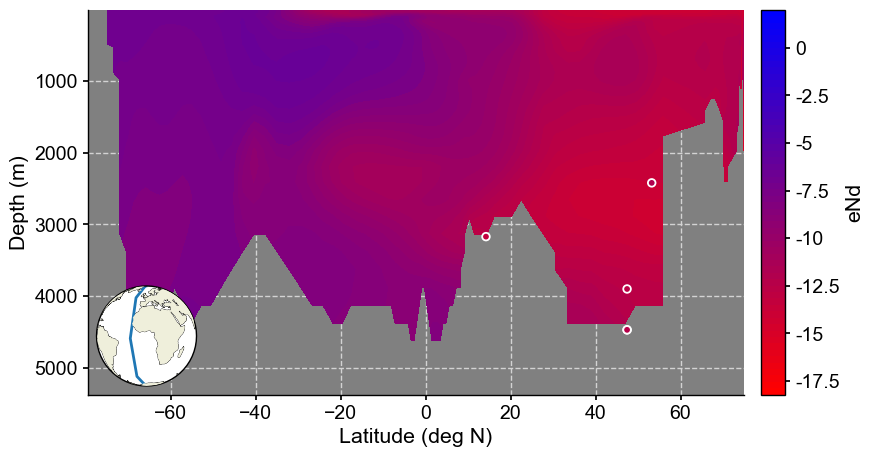

In [203]:
fig = plt.figure(figsize=(9,5));
gs = gridspec.GridSpec(1, 2, wspace=0.05, width_ratios=[8, .3])
ax = fig.add_subplot(gs[0, 0]);
# tmp = query_latlon(ds, lats=None, lons=[None])
ax.patch.set_facecolor('gray')

ax.contourf(section_ds.TLAT.mean(dim='nlon'), section_ds.z_t_m,
                     section_ds[var].mean(dim='nlon').squeeze().data,10, origin='upper',
                         levels=ax2_levels,
                         cmap=ax2_sm.cmap, 
                        norm=ax2_sm.norm)

ax.scatter(section_df['lat'], section_df['depth'], c=section_df['eNd_HOL'],s=30, 
                norm=cf2_kwargs['norm'],cmap=cf2_kwargs['cmap'],
                edgecolors='w',linewidth=1.3)

ylims = ax.get_ylim()
ax.set_ylim([ylims[1], ylims[0]])
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Latitude (deg N)')

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))

make_inset_map(ax, [-90, 90], [341, 341], central_lon=0,central_lat=0, size_scaler=.2, loc='lower left')


Quite remarkable agreement between the Holocene empirical data and the model ouptut!

Note: The locations of measured data are subgrid resolution so it is not surprising to see plotted points floating above the land or seemingly below the surface of the seafloor.

### Uniqueness
As a final experiment, let's assume the uncertainty on each eNd measurement is .2... What other depths at that location (latitude, longitude pair) have a value in that window? This should highlight a few points:
1. How many values in the water column are actually close to the measured value in that location? Color gives a broad sense of agreement, but can be challenging to interpret at a finer scale. 
2. In high latitude places with vertical transport, one would expect a somewhat more homogenous eNd across the water column.
3. In low and mid latitudes, one would expect the range to be more closely tied to a particular depth (which is to say, source region). 

In [154]:
lats = section_ds.TLAT.mean(dim='nlon').squeeze().data
data = section_ds[var].mean(dim='nlon').squeeze().data
depths = section_ds.z_t_m.data
section_ds_df = pd.DataFrame(data, columns=lats, index=depths)


In [155]:
depth_range_plot_d = {'lats':[], 'depth':[], 'eNd':[], 'source':[]} 
window = .3
for _,row in section_df.iterrows():
    try:
        profile_series = section_ds_df[lats[np.argwhere(lats>row['lat'])[0]-1]]#['eNd_HOL']
        # print(row['eNd_HOL'])
        uncertainty_range = profile_series.iloc[:,0][profile_series.iloc[:,0].between(row['eNd_HOL']-window, row['eNd_HOL']+window)]#profile_series.between(row['eNd_HOL']-.2, row['eNd_HOL']+.2)
        depth_range_plot_d['depth']+= uncertainty_range.index.values.tolist()
        depth_range_plot_d['depth'].append(row['depth'])
        depth_range_plot_d['lats'] +=[row['lat'] for ik in range(len(uncertainty_range))]
        depth_range_plot_d['lats'].append(row['lat'])
        depth_range_plot_d['eNd'] += uncertainty_range.values.ravel().tolist()
        depth_range_plot_d['eNd'].append(row['eNd_HOL'])
        depth_range_plot_d['source'] +=['model' for ik in range(len(uncertainty_range))]
        depth_range_plot_d['source'].append('measurement')
    except:
        print(row['Core'])

depth_range_plot_df = pd.DataFrame(depth_range_plot_d)

Now we'll add these points--outlined in black--to the section plot. This will provide some context for the distribution of eNd in the water column.

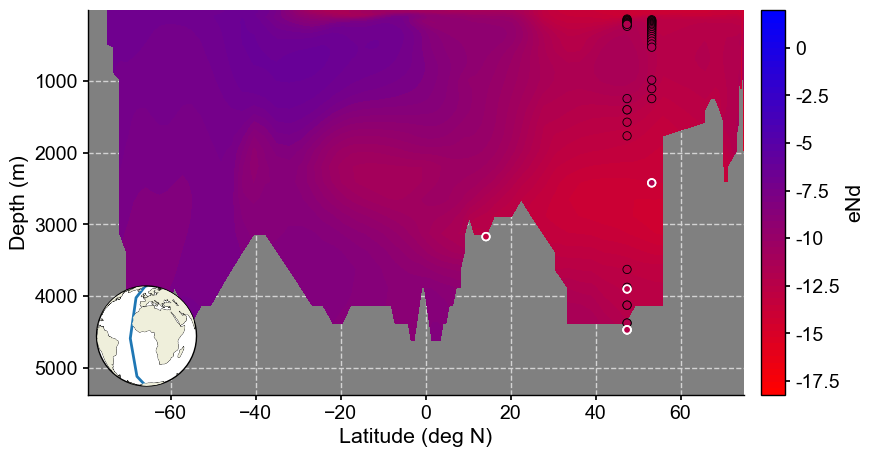

In [205]:
fig = plt.figure(figsize=(9,5));
gs = gridspec.GridSpec(1, 2, wspace=0.05,hspace=.05, width_ratios=[8, .3])
ax = fig.add_subplot(gs[0, 0]);
# tmp = query_latlon(ds, lats=None, lons=[None])
ax.patch.set_facecolor('gray')

ax.contourf(section_ds.TLAT.mean(dim='nlon'), section_ds.z_t_m,
                     section_ds[var].mean(dim='nlon').squeeze().data,10, origin='upper',
                         levels=ax2_levels,
                         cmap=ax2_sm.cmap, 
                        norm=ax2_sm.norm)
ax.scatter(depth_range_plot_df['lats'], depth_range_plot_df['depth'], c=depth_range_plot_df['eNd'], linewidth=.6,
           norm=cf2_kwargs['norm'],cmap=cf2_kwargs['cmap'],edgecolor=['k' if source=='model' else 'w' for source in depth_range_plot_df['source']])

ax.scatter(section_df['lat'], section_df['depth'], c=section_df['eNd_HOL'],s=30, 
                norm=cf2_kwargs['norm'],cmap=cf2_kwargs['cmap'],
                edgecolors='w',linewidth=1.3)

ylims = ax.get_ylim()
ax.set_ylim([ylims[1], ylims[0]])
ax.set_ylabel('Depth (m)')
ax.set_xlabel('Latitude (deg N)')

ax2_cb = fig.add_subplot(gs[0, 1])
cb2 = plt.colorbar(ax2_sm,cax=ax2_cb, orientation='vertical',label=colorbar_units,
                   format=FormatStrFormatter('%g'))

make_inset_map(ax, [-90, 90], [341, 341], central_lon=0,central_lat=0, size_scaler=.2, loc='lower left')
plt.savefig('section_eNd_uncertaintyrange.png', dpi='figure', format='png', metadata=None,
            bbox_inches='tight', #pad_inches=0.1,
            facecolor='auto', edgecolor='auto',
            backend=None)

In [206]:
os.getcwd()

'/Users/jlanders/PycharmProjects/citrace_paleobook/notebooks/science_bits'

The choice of window was somewhat arbitrary, but this plot suggests that at high latitudes, there are model values at multiple locations in the water column that are within range of the measured values. In contrast, the window around the low latitude measurement does not appear to fall within the model range. 

---

## Summary
More to come as inspiration strikes, but these should offer helpful templates!

## Resources and references


| _Citations_|
|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
